In [15]:
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
from sklearn import cluster
from pyproj import Transformer
from shapely.geometry import Point

In [2]:
# G = ox.graph_from_place('middlesex county, NJ, USA', network_type='drive')
# G_projected = ox.project_graph(G)
# nodes, edges = ox.graph_to_gdfs(G)
# ox.plot_graph(G_projected)

In [3]:
Middlesex_target_roadway = gpd.read_file('Middlesex_target_roadway.shp')
Middlesex_target_pts = Middlesex_target_roadway['geometry'].centroid

total_length_in_mile = Middlesex_target_roadway.loc[:, 'geometry'].length.sum() / 5280
total_hours = total_length_in_mile / 20

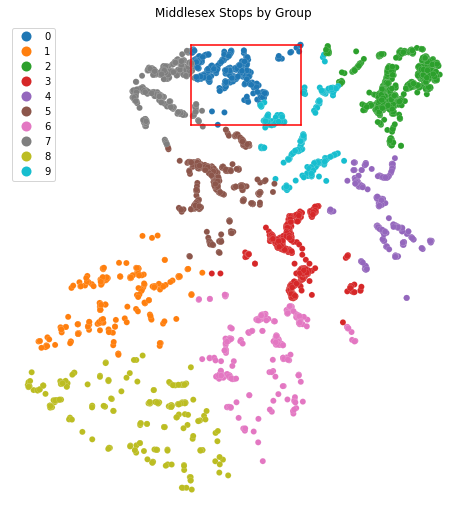

In [192]:
# Categorize target roadways using K-mean
num_group = 10

Middlesex_target_pts = gpd.GeoDataFrame(Middlesex_target_pts, columns=['geometry'])
training_data = np.concatenate((Middlesex_target_pts['geometry'].x.values.reshape(-1, 1), Middlesex_target_pts['geometry'].y.values.reshape(-1, 1)), axis=1)

km5 = cluster.KMeans(n_clusters=num_group)
km5cls = km5.fit(training_data)

Middlesex_target_pts['group'] = km5cls.labels_

# f, ax = plt.subplots(1, figsize=(18, 12))
# Monmouth_target_roadway_mids.assign(cl=km5cls.labels_).plot(column='cl', categorical=True, legend=True,linewidth=0.1, edgecolor='white', ax=ax)
# ax.set_axis_off()
# plt.title("Monmouth County Target Roadway by Group")
# plt.show()

# visualize focal area & bounding box
transformer = Transformer.from_crs(3424, 4326, always_xy=True)

focal_group = 0

boundings_3424 = Middlesex_target_pts.loc[Middlesex_target_pts['group'] == focal_group, 'geometry'].total_bounds
boundings_4326_min = transformer.transform(boundings_3424[0], boundings_3424[1])
boundings_4326_max = transformer.transform(boundings_3424[2], boundings_3424[3])
boundings_4326 = np.concatenate([np.array(boundings_4326_min), np.array(boundings_4326_max)])

bbox = ((boundings_3424[0], boundings_3424[1]),
        (boundings_3424[0], boundings_3424[3]),
        (boundings_3424[2], boundings_3424[3]),
        (boundings_3424[2], boundings_3424[1]),
        (boundings_3424[0], boundings_3424[1]))

f, ax = plt.subplots(1, figsize=(9, 9))
for i in range(len(bbox)-1):
    plt.plot((bbox[i][0], bbox[i+1][0]), (bbox[i][1], bbox[i+1][1]), color='red')
Middlesex_target_pts.assign(cl=km5cls.labels_).plot(column='cl', categorical=True, legend=True,linewidth=0.1, edgecolor='white', ax=ax)
ax.set_axis_off()
plt.title("Middlesex Stops by Group")
plt.show()

In [329]:
Middlesex_target_roadway_by_grp = pd.concat([Middlesex_target_roadway[['OBJECTID', 'geometry']], Middlesex_target_pts['group']], axis=1)
Middlesex_target_roadway_by_grp.head()

,OBJECTID,geometry,group
0,426772,"LINESTRING (484868.910 579120.730, 484941.590 ...",1
1,51467,"LINESTRING (561743.144 642540.880, 561743.630 ...",2
2,314480,"LINESTRING (498883.820 625239.290, 498891.740 ...",7
3,291874,"LINESTRING (537343.920 611064.290, 537230.430 ...",9
4,54755,"LINESTRING (558474.520 635897.340, 558726.727 ...",2


In [5]:
# get the Monmouth roadway network within the focal area
# G = ox.graph_from_bbox(boundings_4326[3], boundings_4326[1], boundings_4326[2], boundings_4326[0], network_type='drive') # ymax, ymin, xmax, xmin
# nodes, edges = ox.graph_to_gdfs(G)
# G_projected = ox.project_graph(G)
# ox.plot_graph(G_projected)

In [7]:
Middlesex_roadway = gpd.read_file("Middlesex_roadway_split_for_network.shp")
Middlesex_roadway.head()

,OBJECTID,SEG_GUID,PRIME_NAME,ADDR_L_FR,ADDR_L_TO,ADDR_R_FR,ADDR_R_TO,ZIPCODE_L,ZIPCODE_R,ZIPNAME_L,...,H3_NAME,H3_SHLD,H3_SUBSHLD,H3_NUM,FEATSTATUS,UPDATEDATE,SHAPE_Leng,Miles,Shape_Le_1,geometry
0,142238,{2D7112F0-1708-11E3-B5F2-0062151309FF},None,0,0,0,0,08902,08902,NORTH BRUNSWICK,...,None,None,None,None,D,2016-01-07,41.402881,0.007841,41.402928,"LINESTRING (504528.177 593881.858, 504487.991 ..."
1,286769,{3581432A-1708-11E3-B5F2-0062151309FF},None,0,0,0,0,08901,08901,NEW BRUNSWICK,...,None,None,None,None,F,2013-10-28,126.915547,0.024037,126.914551,"LINESTRING (512217.850 598227.810, 512238.769 ..."
2,54753,{21C4FCA0-1708-11E3-B5F2-0062151309FF},Wood Ave,469,489,474,498,08820,08830,EDISON,...,None,None,None,None,F,2014-06-10,252.426541,0.047808,252.426484,"LINESTRING (537450.150 636833.640, 537439.250 ..."
3,151874,{2842E4AC-1708-11E3-B5F2-0062151309FF},Vaughn Ave,47,17,54,18,08884,08884,SPOTSWOOD,...,None,None,None,None,F,2014-06-09,488.905987,0.092596,488.905925,"LINESTRING (522904.200 571226.700, 522950.304 ..."
4,390683,{34F4D12E-1708-11E3-B5F2-0062151309FF},Snapper Ave,22,98,21,99,08882,08882,SOUTH RIVER,...,None,None,None,None,F,2014-06-04,267.283555,0.050622,267.283660,"LINESTRING (522115.040 588432.190, 521940.244 ..."


# construct network from geodataframe

In [64]:
total_edges = len(Middlesex_roadway)

Nodes_set = set()
Roadway_Nodes = pd.DataFrame(columns=['OBJECTID', 'geometry'])
Roadway_Edges = pd.DataFrame(index=Middlesex_roadway.index, columns=['OBJECTID', 'nodes', 'length'])

n = 0

for i in Middlesex_roadway.index:
    node_pair = []
    line = Middlesex_roadway.loc[i, 'geometry']
    for pts in (line.coords[0], line.coords[-1]):
        if not pts in Nodes_set:
            temp_df = pd.DataFrame({n:{'OBJECTID': Middlesex_roadway.loc[i, 'OBJECTID'], 'geometry': pts}}).T
            Roadway_Nodes = pd.concat([Roadway_Nodes, temp_df], axis=0)
            n += 1
            Nodes_set.add(pts)
        node_pair.append(Roadway_Nodes.loc[Roadway_Nodes['geometry'] == pts, :].index[0])
        
    Roadway_Edges.loc[i, 'OBJECTID'] = Middlesex_roadway.loc[i, 'OBJECTID']
    Roadway_Edges.loc[i, 'nodes'] = tuple(node_pair)
    Roadway_Edges.loc[i, 'length'] = Middlesex_roadway.loc[i, 'geometry'].length
    
    print("progress: %d / %d" % (i, total_edges), end='\r')

In [296]:
Roadway_Nodes_new['OBJECTID'] = Roadway_Nodes_new['OBJECTID'].astype(int)
gpd.GeoDataFrame(Roadway_Nodes_new).to_file("splited_nodes.shp")

In [117]:
Roadway_Edges_new = Roadway_Edges.copy()
Roadway_Edges_new.insert(1, 'node_0', np.array([list(edge) for edge in Roadway_Edges['nodes']])[:, 0])
Roadway_Edges_new.insert(2, 'node_1', np.array([list(edge) for edge in Roadway_Edges['nodes']])[:, 1])
Roadway_Edges_new

,OBJECTID,node_0,node_1,nodes,length
0,142238,0,1,"(0, 1)",41.402928
1,286769,2,3,"(2, 3)",126.914551
2,54753,4,5,"(4, 5)",252.426484
3,151874,6,7,"(6, 7)",488.905925
4,390683,8,9,"(8, 9)",267.28366
...,...,...,...,...,...
46683,87374,29975,35729,"(29975, 35729)",96.379882
46684,119059,22499,33874,"(22499, 33874)",35.820046
46685,202514,22010,27704,"(22010, 27704)",322.386213
46686,48564,3038,26929,"(3038, 26929)",481.881063


In [118]:
Roadway_network = nx.from_pandas_edgelist(Roadway_Edges_new, 'node_0', 'node_1', edge_attr='length')
Roadway_network

In [120]:
Roadway_network[0][1]

{'length': 41.4029280206631}

In [ ]:
Roadway_network

# Process target roadways

In [121]:
Roadway_Nodes_new = Roadway_Nodes.copy()
Roadway_Nodes_new = gpd.GeoDataFrame(Roadway_Nodes_new, crs="EPSG:3424")
Roadway_Nodes_new['geometry'] = [Point(pts) for pts in Roadway_Nodes_new['geometry']]
type(Roadway_Nodes_new)

geopandas.geodataframe.GeoDataFrame

In [270]:
Roadway_Nodes

,OBJECTID,geometry
0,142238,POINT (504528.177 593881.858)
1,142238,POINT (504487.991 593871.895)
2,286769,POINT (512217.850 598227.810)
3,286769,POINT (512260.610 598347.300)
4,54753,POINT (537450.150 636833.640)
...,...,...
35725,152143,POINT (519799.630 623968.828)
35726,1229,POINT (550957.747 589262.811)
35727,110565,POINT (504153.976 537245.395)
35728,76158,POINT (552061.428 627218.636)


In [304]:
type(Roadway_Nodes_new)

geopandas.geodataframe.GeoDataFrame

In [276]:
Middlesex_target_roadway.loc[30, :]

OBJECTID                                                  61175
SEG_GUID                 {0BBBEC66-1708-11E3-B5F2-0062151309FF}
PRIME_NAME                                           US Hwy 130
ADDR_L_FR                                                     0
ADDR_L_TO                                                     0
ADDR_R_FR                                                  2152
ADDR_R_TO                                                  2198
ZIPCODE_L                                                 08852
ZIPCODE_R                                                 08852
ZIPNAME_L                                     MONMOUTH JUNCTION
ZIPNAME_R                                     MONMOUTH JUNCTION
MUNI_L                                                   882162
MUNI_R                                                   882162
STATE_L                                                      NJ
STATE_R                                                      NJ
SYMBOLTYPE                              

In [319]:
target_roadway_raw = gpd.sjoin(Middlesex_target_roadway, gpd.GeoDataFrame(Roadway_Nodes_new.buffer(5), columns=['geometry']), how='left', op='intersects')
target_roadway_raw

,OBJECTID,SEG_GUID,PRIME_NAME,ADDR_L_FR,ADDR_L_TO,ADDR_R_FR,ADDR_R_TO,ZIPCODE_L,ZIPCODE_R,ZIPNAME_L,...,H3_SHLD,H3_SUBSHLD,H3_NUM,FEATSTATUS,UPDATEDATE,SHAPE_Leng,Miles,Shape_Le_1,geometry,index_right
0,426772,{294BD84A-1708-11E3-B5F2-0062151309FF},US Hwy 1,0,0,3759,3749,08852,08824,MONMOUTH JUNCTION,...,None,None,None,F,2016-05-06,105.840191,0.020045,105.840270,"LINESTRING (484868.910 579120.730, 484941.590 ...",16712
0,426772,{294BD84A-1708-11E3-B5F2-0062151309FF},US Hwy 1,0,0,3759,3749,08852,08824,MONMOUTH JUNCTION,...,None,None,None,F,2016-05-06,105.840191,0.020045,105.840270,"LINESTRING (484868.910 579120.730, 484941.590 ...",13914
1,51467,{069F71E4-1708-11E3-B5F2-0062151309FF},Dalbert St,0,0,0,0,07008,07008,CARTERET,...,None,None,None,F,2014-06-09,166.447331,0.031524,166.447222,"LINESTRING (561743.144 642540.880, 561743.630 ...",14603
1,51467,{069F71E4-1708-11E3-B5F2-0062151309FF},Dalbert St,0,0,0,0,07008,07008,CARTERET,...,None,None,None,F,2014-06-09,166.447331,0.031524,166.447222,"LINESTRING (561743.144 642540.880, 561743.630 ...",17897
2,314480,{104A9E12-1708-11E3-B5F2-0062151309FF},OLD New Brunswick Rd,0,0,279,251,08854,08854,PISCATAWAY,...,None,None,None,F,2016-05-06,43.969181,0.008327,43.969143,"LINESTRING (498883.820 625239.290, 498891.740 ...",12117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437,393378,{097ADD04-1708-11E3-B5F2-0062151309FF},None,0,0,0,0,08872,08872,SAYREVILLE,...,None,None,None,F,2013-11-06,166.125542,0.031463,166.125482,"LINESTRING (533391.106 581060.660, 533409.020 ...",13751
4438,272097,{29D624B4-1708-11E3-B5F2-0062151309FF},Raritan Center Pkwy,452,398,401,399,08837,08837,EDISON,...,None,None,None,F,2016-05-06,608.500809,0.115246,608.500784,"LINESTRING (535499.148 608574.228, 535507.758 ...",26313
4438,272097,{29D624B4-1708-11E3-B5F2-0062151309FF},Raritan Center Pkwy,452,398,401,399,08837,08837,EDISON,...,None,None,None,F,2016-05-06,608.500809,0.115246,608.500784,"LINESTRING (535499.148 608574.228, 535507.758 ...",26312
4439,249218,{2D36B3DA-1708-11E3-B5F2-0062151309FF},Chevalier Ave Con,0,0,0,0,08879,08879,SOUTH AMBOY,...,None,None,None,F,2014-06-04,138.774698,0.026283,73.570493,"LINESTRING (547849.030 605468.970, 547811.090 ...",22998


In [323]:
Target_Roadway_df = pd.DataFrame(index=target_roadway_raw.index.unique(), columns=['nodes'])

for edge_ix in Target_Roadway_df.index:
#     temp = target_roadway_raw.loc[edge_ix, :]
#     node_lst = []
#     for node_ix in temp.index:
#         node_lst.append(temp.loc[node_ix, 'index_right'])
#         length = temp.loc[node_ix, 'geometry'].length
    if isinstance(target_roadway_raw.loc[edge_ix, 'index_right'], np.int64):
        Target_Roadway_df.loc[edge_ix, 'nodes'] = np.repeat(target_roadway_raw.loc[edge_ix, 'index_right'], 2)
        print(Middlesex_target_roadway.loc[edge_ix, 'OBJECTID'])
        print(Target_Roadway_df.loc[edge_ix, 'nodes'])
    else:
        Target_Roadway_df.loc[edge_ix, 'nodes'] = np.array(target_roadway_raw.loc[edge_ix, 'index_right'])
#     Target_Roadway_df.loc[edge_ix, 'length'] = length

Target_Roadway_df

256791
[24739 24739]
80101
[29734 29734]
444878
[31196 31196]
474577
[26431 26431]
53897
[21855 21855]
28036
[7237 7237]
45353
[17779 17779]
117322
[10762 10762]
314517
[15909 15909]
159074
[27382 27382]
360773
[19478 19478]
411265
[31148 31148]
441453
[23475 23475]
425114
[29577 29577]
358864
[14241 14241]


,nodes
0,"[16712, 13914]"
1,"[14603, 17897]"
2,"[12117, 29618]"
3,"[10032, 9021]"
4,"[26953, 26952]"
...,...
4435,"[22643, 22642]"
4436,"[10762, 7240]"
4437,"[32147, 13751]"
4438,"[26313, 26312]"


In [330]:
Middlesex_target_roadway_by_grp = pd.concat([Middlesex_target_roadway_by_grp, Target_Roadway_df], axis=1)
Target_edges_by_grp = Middlesex_target_roadway_by_grp.loc[Middlesex_target_roadway_by_grp['group']==9, :]
Target_edges_by_grp

,OBJECTID,geometry,group,nodes
3,291874,"LINESTRING (537343.920 611064.290, 537230.430 ...",9,"[10032, 9021]"
15,413218,"LINESTRING (524749.580 622713.850, 524902.240 ...",9,"[10273, 2097]"
20,118525,"LINESTRING (536193.031 611012.305, 536202.284 ...",9,"[9984, 4840]"
56,116125,"LINESTRING (541550.470 630898.900, 541527.579 ...",9,"[13388, 1880]"
79,224421,"MULTILINESTRING ((525092.930 622518.230, 52507...",9,"[17328, 30530, 30529, 26155]"
...,...,...,...,...
4345,123847,"LINESTRING (533257.790 618946.310, 533272.277 ...",9,"[28874, 1474]"
4395,90591,"LINESTRING (533609.230 606908.360, 533483.249 ...",9,"[470, 471]"
4403,106456,"LINESTRING (539198.625 611533.303, 539209.320 ...",9,"[15667, 18005]"
4414,291550,"LINESTRING (527638.414 624168.274, 527232.780 ...",9,"[6009, 6008]"


# Construct complete graph for the focal edges (roadways)

In [333]:
n = 0

G_TSP = nx.Graph()
G_TSP.add_nodes_from(Target_edges_by_grp.index)

kn = nx.complete_graph(G_TSP)

for edge_pair in kn.edges:
    distances = []
    
    for node_0 in Target_edges_by_grp.loc[edge_pair[0], 'nodes']:
        for node_1 in Target_edges_by_grp.loc[edge_pair[1], 'nodes']:
            if nx.has_path(Roadway_network, node_0, node_1):
                distances.append(nx.dijkstra_path_length(Roadway_network, node_0, node_1, weight='length'))
            else:
                distances.append(np.Inf)
            
    kn[edge_pair[0]][edge_pair[1]]['length'] = min(distances)
    print("%d / %d" % (n, len(kn.edges)), end='\r')
    n += 1

In [334]:
kn.edges

EdgeView([(3, 15), (3, 20), (3, 56), (3, 79), (3, 96), (3, 98), (3, 108), (3, 110), (3, 117), (3, 123), (3, 144), (3, 176), (3, 202), (3, 203), (3, 206), (3, 211), (3, 220), (3, 242), (3, 243), (3, 250), (3, 254), (3, 259), (3, 262), (3, 288), (3, 290), (3, 308), (3, 325), (3, 358), (3, 370), (3, 394), (3, 407), (3, 408), (3, 409), (3, 412), (3, 436), (3, 443), (3, 457), (3, 466), (3, 476), (3, 479), (3, 488), (3, 493), (3, 581), (3, 594), (3, 632), (3, 637), (3, 638), (3, 645), (3, 683), (3, 698), (3, 706), (3, 711), (3, 731), (3, 743), (3, 748), (3, 758), (3, 762), (3, 777), (3, 794), (3, 802), (3, 810), (3, 825), (3, 832), (3, 833), (3, 847), (3, 854), (3, 858), (3, 863), (3, 875), (3, 883), (3, 885), (3, 892), (3, 911), (3, 922), (3, 924), (3, 940), (3, 946), (3, 959), (3, 965), (3, 968), (3, 970), (3, 978), (3, 983), (3, 986), (3, 1013), (3, 1034), (3, 1035), (3, 1045), (3, 1056), (3, 1071), (3, 1088), (3, 1097), (3, 1099), (3, 1120), (3, 1121), (3, 1132), (3, 1145), (3, 1164), (3

In [336]:
min_spanning_tree = nx.minimum_spanning_tree(kn, weight='length')

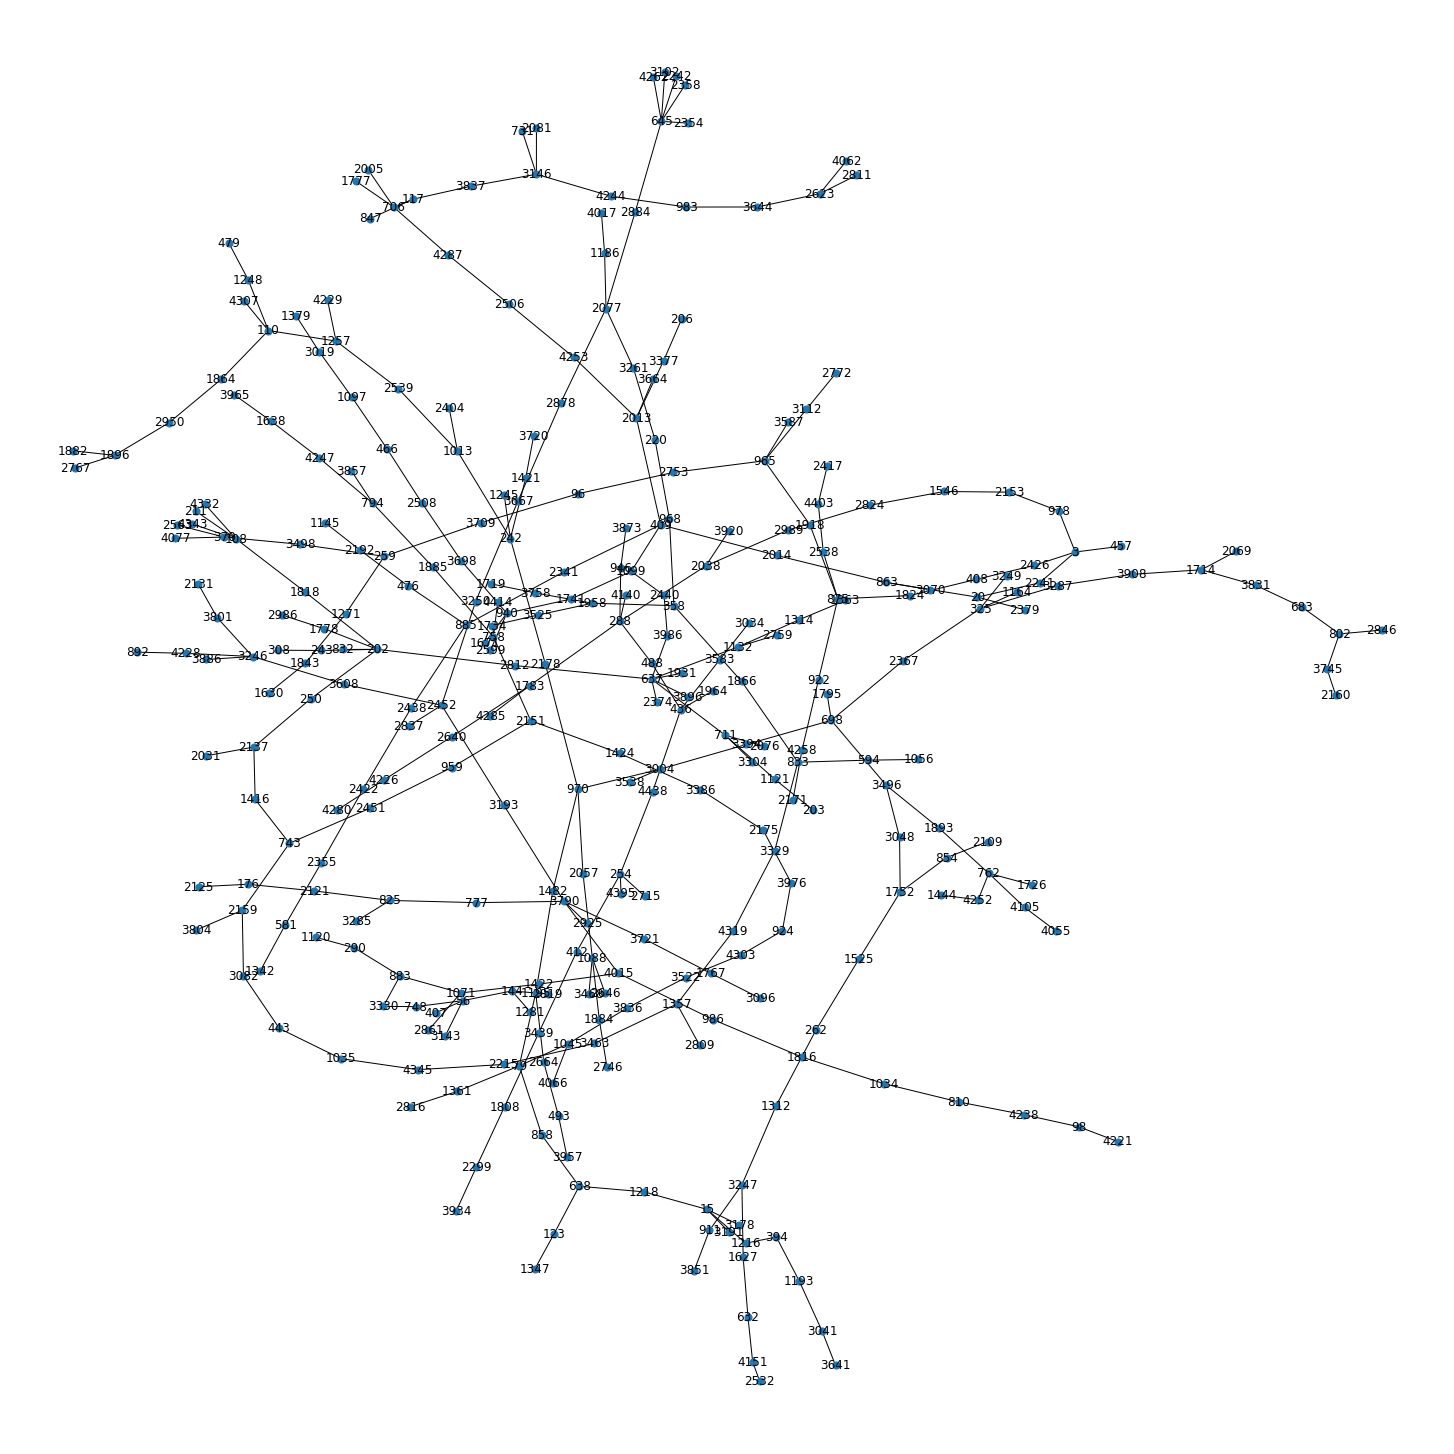

In [337]:
plt.figure(figsize=(20,20))
nx.draw(min_spanning_tree,with_labels=True, node_size=50)

In [338]:
odd_degree_nodes = [node for (node, degree) in min_spanning_tree.degree if degree % 2 == 1]
nodes_to_remove = list(set(kn.nodes)-set(odd_degree_nodes))

kn_negative = kn.copy()
kn_negative.remove_nodes_from(nodes_to_remove)

for edge in kn_negative.edges:
    kn_negative[edge[0]][edge[1]]['length'] *= -1
    
min_cost_perfect_matching = nx.algorithms.matching.max_weight_matching(kn_negative, maxcardinality=True, weight='length')
print("minimum cost perfect matching complete!")

minimum cost perfect matching complete!


In [339]:
min_spanning_tree_2 = min_spanning_tree.copy()
for edge in min_cost_perfect_matching:
    if not min_spanning_tree.has_edge(edge[0], edge[1]):
        min_spanning_tree.add_edge(edge[0], edge[1], length = kn[edge[0]][edge[1]]['length'])
        min_spanning_tree_2.add_edge(edge[0], edge[1], length = kn[edge[0]][edge[1]]['length'])
    else:
        min_spanning_tree_2.remove_edge(edge[0], edge[1])
        
min_spanning_tree_recon = set(min_spanning_tree.to_directed().edges) - set(min_spanning_tree_2.edges)

In [343]:
def DFS(start_node, df):
    forward_visitation = []
    next_node = np.nan
    current_node = start_node
    forward_visitation.append(start_node)
    while next_node != start_node:
        
        candidate_edges = df[((df[-1] == current_node) | (df[1] == current_node)) & (df['visited'] == False)].index
        selected_edge = np.random.choice(candidate_edges)
        df.loc[selected_edge, 'visited'] = True

        if df.loc[selected_edge, -1] == current_node:
            next_node = df.loc[selected_edge, 1]
        else:
            next_node = df.loc[selected_edge, -1]

        current_node = next_node
        
        forward_visitation.append(current_node)
        
    return(forward_visitation)

edge_df = pd.DataFrame(min_spanning_tree_recon, columns=[-1, 1])
edge_df.insert(2, 'visited', False)

subloops = []

while False in edge_df['visited'].values:
    subloops.append(DFS(np.random.choice(edge_df.loc[edge_df['visited']== False, -1].values), edge_df))

In [344]:
# specify origin of the trip
origin = 3330

subloops_reduction = subloops.copy()

# initializing output
base_loop = np.array(subloops[0])
subloops_reduction.remove(subloops[0])

while len(subloops_reduction) > 0:
    for subloop in subloops_reduction:
        temp_loop = np.array(subloop)
        common_node = set(base_loop).intersection(set(temp_loop))
        if len(common_node) > 0:
            pos_baseloop = np.where(np.array(base_loop) == list(common_node)[0])[0]
            pos_temploop = np.where(np.array(temp_loop) == list(common_node)[0])[0]
            # modify nodes position of temp loop
            temp_loop_mod = np.concatenate((temp_loop[pos_temploop[0]:], temp_loop[1:pos_temploop[0]]))
            # connect subloops
            base_loop = np.insert(base_loop, pos_baseloop[0], temp_loop_mod)
            subloops_reduction.remove(subloop)

pos = np.where(base_loop == origin)[0][0]
trip = np.concatenate([base_loop[pos:], base_loop[1:pos], np.array([base_loop[pos] for pos in np.where(base_loop == origin)[0] if not base_loop[pos] == base_loop[-1]])])
            
len(trip)

407

In [345]:
trip

array([3330,  883, 1120,  290,  883, 1071, 2861, 4015, 3790, 2925, 2125,
        176, 2121,  825, 3285,  825,  777, 3790, 3721, 1767, 3096, 1734,
       3525, 1958, 3758, 1719, 1958,  358, 1630, 1843, 1271,  259, 3498,
        370, 2563,  370, 4077,  259, 3709,   96, 2753,  965, 3587, 2772,
       3112,  965, 1918,  875,  922, 4258, 2171, 2417, 4403, 2538,  875,
       1824,  408, 2426,    3, 2241,   20,  863,   20, 2379,  457,    3,
        978, 2153, 1546, 2824, 2989, 2038, 3920, 2038,  288,  488,  436,
       3583, 3034, 4395,  254, 4438,  436, 1964, 2715,  254,  412, 3439,
       1808, 2299, 3934, 4280, 4226, 2640, 1783, 4285, 1783,  288, 4140,
        288,  946, 3873, 3070,  863, 2014,  409, 2013, 3664,  206, 3377,
       2013, 4253, 2506, 4287,  706, 1777, 2005,  706,  117,  847,  117,
       3837, 3146, 4244,  983, 3644, 2623, 2811, 2623, 4062, 2081, 3146,
        731,  802, 2846, 2160, 3745,  802,  683, 3831, 1714, 2069, 1714,
       3908, 3287,  325, 3249, 1164,  325, 2367,  6

In [352]:
Middlesex_target_roadway.loc[trip, :]

,OBJECTID,SEG_GUID,PRIME_NAME,ADDR_L_FR,ADDR_L_TO,ADDR_R_FR,ADDR_R_TO,ZIPCODE_L,ZIPCODE_R,ZIPNAME_L,...,H3_NAME,H3_SHLD,H3_SUBSHLD,H3_NUM,FEATSTATUS,UPDATEDATE,SHAPE_Leng,Miles,Shape_Le_1,geometry
3330,288630,{28E50BEC-1708-11E3-B5F2-0062151309FF},Gill Ln,86,2,79,1,08830,08830,ISELIN,...,None,None,None,None,F,2014-06-09,208.994167,0.039582,208.994050,"LINESTRING (541262.680 631601.500, 541242.880 ..."
883,433066,{282A480C-1708-11E3-B5F2-0062151309FF},None,0,0,0,0,08830,08830,ISELIN,...,None,None,None,None,F,2013-11-06,191.755754,0.036317,191.755762,"LINESTRING (541197.078 631799.874, 541016.674 ..."
1120,451163,{08F91A80-1708-11E3-B5F2-0062151309FF},None,0,0,0,0,08830,08830,ISELIN,...,None,None,None,None,F,2013-11-06,295.434937,0.055954,295.434806,"LINESTRING (541016.674 631734.876, 540922.829 ..."
290,271528,{2B1F037C-1708-11E3-B5F2-0062151309FF},None,0,0,0,0,08830,08830,ISELIN,...,None,None,None,None,F,2013-11-06,202.725502,0.038395,202.725483,"LINESTRING (541016.674 631734.876, 540817.779 ..."
883,433066,{282A480C-1708-11E3-B5F2-0062151309FF},None,0,0,0,0,08830,08830,ISELIN,...,None,None,None,None,F,2013-11-06,191.755754,0.036317,191.755762,"LINESTRING (541197.078 631799.874, 541016.674 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,304465,{262AC0D6-1708-11E3-B5F2-0062151309FF},Gill Ln,0,0,321,201,08830,08830,ISELIN,...,None,None,None,None,F,2014-06-10,2263.603279,0.428713,12.152894,"LINESTRING (541559.197 630890.443, 541550.470 ..."
3143,239241,{24D21306-1708-11E3-B5F2-0062151309FF},Tammy Pl,199,1,198,2,08830,08830,ISELIN,...,None,None,None,None,F,2014-06-10,586.050437,0.110984,169.620477,"LINESTRING (541550.470 630898.900, 541667.863 ..."
56,116125,{12ED4D36-1708-11E3-B5F2-0062151309FF},Gill Ln,0,0,199,123,08830,08830,ISELIN,...,None,None,None,None,F,2014-06-09,304.337975,0.057640,304.338162,"LINESTRING (541550.470 630898.900, 541527.579 ..."
748,379987,{092FD674-1708-11E3-B5F2-0062151309FF},Gill Ln,98,88,121,81,08830,08830,ISELIN,...,None,None,None,None,F,2014-06-04,468.147915,0.088664,468.147817,"LINESTRING (541475.310 631185.570, 541467.240 ..."


In [351]:
Middlesex_target_roadway.loc[trip, :].to_file("Middlesex_trip_group_9.shp")